We're testing Gemini's Argo data loading code here.

In [ ]:
import numpy as np
import argopy
from argopy import DataFetcher
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw


In [ ]:
# --- SECTION 1: CONFIGURATION ---
# Define the "Arena" for the California Current
# Format: [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
# We look at 0-600m depth to capture the subsurface signal and a bit of the deeper ocean signal
# We restrict longitude to -126 to -120 to stay close to the coast.
region_box = [-126, -120, 30, 40, 0, 600]

In [3]:
# Define the Time Window
# We'll look at the last 4 years (2023-2024) for this test run.
start_date = '2023-01-01'
end_date = '2024-12-31'

print(f"🌊 Setting up query for California Current: {region_box}")
print(f"📅 Timeframe: {start_date} to {end_date}")

🌊 Setting up query for California Current: [-126, -120, 30, 40, 0, 500]
📅 Timeframe: 2023-01-01 to 2024-12-31


In [4]:
# --- SECTION 2: FETCHING THE INDEX (METADATA) ---
# We use the 'erddap' source as it's often faster for regional queries.
# We fetch the 'index' first, not the data. This returns a Pandas DataFrame of LOCATIONS.

# REQUIRES numpy<2.0 BECAUSE OF HOW XARRAY, PANDAS, AND ARGOPY HANDLE ARGO DATA
try:
    loader = DataFetcher(src='erddap')
    
    # .float() selects Argo floats
    # .region() sets the box and time
    # .to_index() grabs just the metadata (lat/lon/time), not the heavy sensor data
    index_df = loader.region(region_box + [start_date, end_date]).to_index()
    
    print(f"✅ Success! Found {len(index_df)} profiles in this region.")
    
except Exception as e:
    print(f"❌ Error fetching data: {e}")
    # Common error: ERDDAP might be busy. Retry or check internet.
    index_df = None

✅ Success! Found 1056 profiles in this region.


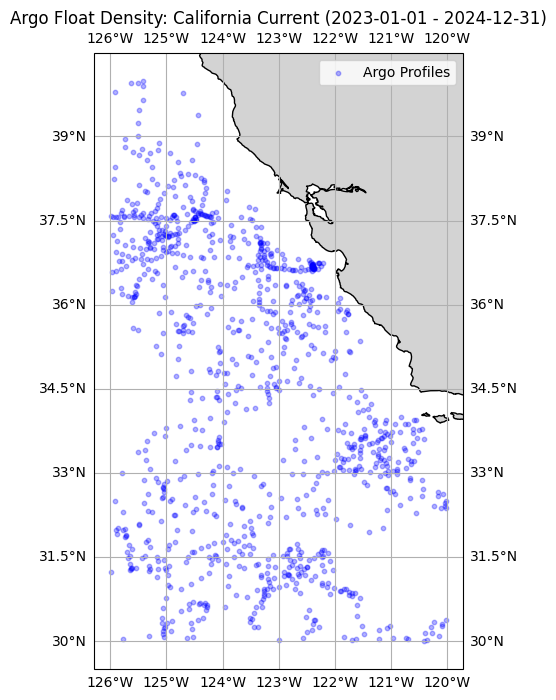

🗺️ Map generated. Check 'california_argo_scout_23to24.png'


In [5]:
# --- SECTION 3: VISUALIZATION (THE MAP) ---
if index_df is not None:
    fig = plt.figure(figsize=(10, 8))
    
    # Use PlateCarree projection (standard lat/lon)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add land features so we can see the coast
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    
    # Plot the profiles
    # We use 'alpha=0.3' to make points semi-transparent. 
    # Darker areas = More data (Good for statistics!)
    sc = ax.scatter(index_df['longitude'], index_df['latitude'], 
                    s=10, c='blue', alpha=0.3, transform=ccrs.PlateCarree(),
                    label='Argo Profiles')
    
    # Formatting
    ax.set_title(f"Argo Float Density: California Current ({start_date} - {end_date})")
    ax.gridlines(draw_labels=True)
    plt.legend()
    
    # Save the map to check it
    plt.savefig('california_argo_scout_23to24.png')
    plt.show()
    
    print("🗺️ Map generated. Check 'california_argo_scout_23to24.png'")

In [6]:
# Quick Check: How many unique floats?
# Argo floats have unique WMO IDs.
unique_floats = index_df['wmo'].nunique()
print(f"🤖 Total unique floats found: {unique_floats}")

if unique_floats < 5:
    print("⚠️ Warning: Low float count. We might need to expand the box slightly offshore.")
else:
    print("🚀 Status: Good data density for analysis.")

🤖 Total unique floats found: 24
🚀 Status: Good data density for analysis.


In [ ]:
print("⬇️ Initializing Argo Download... (This may take 1-5 minutes)")

# --- SECTION 4: THE DOWNLOAD ---
# We use standard mode. 
# 'expert' mode gives more control, but 'standard' handles QC automatically.
try:
    fetcher = DataFetcher(src='erddap', mode='standard')
    
    # Request the data
    # This pulls Temperature (TEMP) and Pressure (PRES) by default
    ds_raw = fetcher.region(region_box + [start_date, end_date]).to_xarray()
    
    print("✅ Download Complete!")
    print(f"📦 Raw Data Shape: {ds_raw.dims}")

except Exception as e:
    print(f"❌ Download Failed: {e}")
    ds_raw = None

# --- SECTION 5: TRANSFORMATION & INTERPOLATION ---
if ds_raw is not None:
    print("🔄 Processing: Converting 'Points' to 'Profiles'...")
    
    # 1. Organizing: Group the messy points into distinct profiles
    # This transforms the data from a long list of points to a matrix of [N_profiles, N_levels]
    ds_profiles = ds_raw.argo.point2profile()
    
    # 2. Interpolation: We need a standard depth ruler for OHC calculation.
    # We will interpolate data to every 5 meters from 0 to 500m.
    print("📏 Interpolating to standard levels (0-600m @ 5m steps)...")
    
    # Define standard depth levels
    std_levels = np.arange(0, 605, 5) 
    
    # Argopy has a handy tool for this, but xarray interpolation is robust.
    # We interpolate the 'TEMP' variable along the 'PRES' dimension.
    ds_interp = ds_profiles.argo.interp_std_levels(std_levels)
    
    # --- SECTION 6: CLEANING & SAVING ---
    # We only need Temperature, Time, Latitude, Longitude for OHC
    # Dropping extra variables saves disk space.
    final_ds = ds_interp[['TEMP']]
    
    print("💾 Saving to NetCDF...")
    filename = 'california_current_argo_2021_2024.nc'
    final_ds.to_netcdf(filename)
    print(f"🎉 Success! Data saved to: {filename}")

 

⬇️ Initializing Argo Download... (This may take 1-5 minutes)
✅ Download Complete!
📦 Raw Data Shape: FrozenMappingWarningOnValuesAccess({'N_POINTS': 263095})
🔄 Processing: Converting 'Points' to 'Profiles'...
📏 Interpolating to standard levels (0-500m @ 5m steps)...
💾 Saving to NetCDF...
🎉 Success! Data saved to: california_current_argo_2021_2024.nc


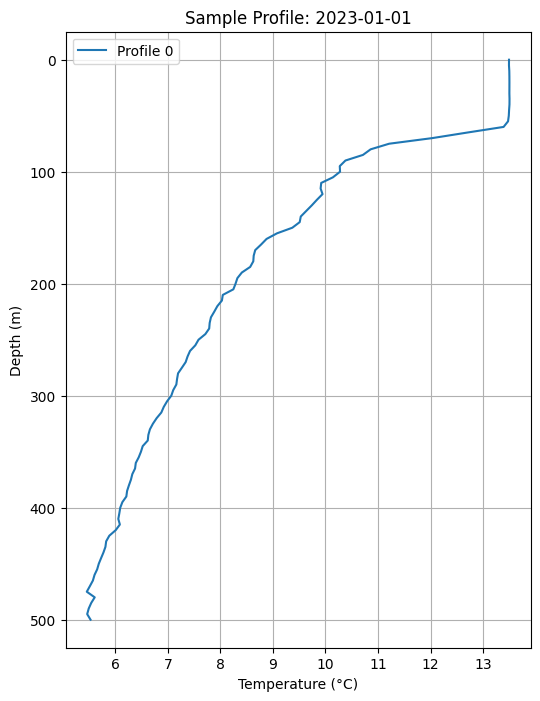

📊 Dataset Info:
<xarray.Dataset> Size: 248kB
Dimensions:            (N_PROF: 567, PRES_INTERPOLATED: 101)
Coordinates:
  * N_PROF             (N_PROF) int64 5kB 372 757 87 300 476 ... 535 969 566 638
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 808B 0 5 10 15 ... 490 495 500
    LATITUDE           (N_PROF) float64 5kB 38.89 34.17 34.25 ... 31.79 35.05
    LONGITUDE          (N_PROF) float64 5kB -125.1 -123.4 ... -123.7 -122.0
    TIME               (N_PROF) datetime64[ns] 5kB 2023-01-01T03:13:24 ... 20...
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 229kB 13.49 ... 5.598
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           avik2007
    Fetched_date:         2025/12/07
    Fetched_constraints:  [x=-126.00/-120.00; y=30.00/40.00; z=0.0/500.0; t=2...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Process

In [8]:
   # --- SECTION 7: VISUAL CHECK ---
    # Let's plot the first profile to make sure it looks like an ocean.
   plt.figure(figsize=(6, 8))
   
   # Select the first profile (isel selects by index)
   sample = final_ds.isel(N_PROF=0)
   
   plt.plot(sample['TEMP'], sample['PRES_INTERPOLATED'], label='Profile 0')
   plt.gca().invert_yaxis() # Oceanography standard: Surface (0) is at top
   plt.grid(True)
   plt.title(f"Sample Profile: {str(sample['TIME'].values)[:10]}")
   plt.xlabel("Temperature (°C)")
   plt.ylabel("Depth (m)")
   plt.legend()
   plt.show()

   print(f"📊 Dataset Info:\n{final_ds}")

In [ ]:
# Now, we're ready to start calculating ocean heat content
# first, we need to incorporate the ocean equation of state, to get salinity, density, and conservative temperature
# import gsw (added this above)

In [ ]:
# we need a function to calculate the density/salinity/temperature and incorporate it into our
# xarray structures

# --- HELPER FUNCTION FOR APPLY_UFUNC ---
def calculate_thermodynamics(sp, t, p, lon, lat):
    """
    Wrapper for GSW functions to be used with apply_ufunc.
    Inputs are expected to be numpy arrays (handled by xarray wrapper).
    """
    # 1. Absolute Salinity (SA)
    # GSW requires (SP, P, lon, lat)
    # We ensure P is broadcasted correctly by xarray before it gets here
    sa = gsw.SA_from_SP(sp, p, lon, lat)
    
    # 2. Conservative Temperature (CT)
    ct = gsw.CT_from_t(sa, t, p)
    
    # 3. Density (rho)
    rho = gsw.rho(sa, ct, p)
    
    # 4. Specific Heat Capacity (Cp)
    cp = gsw.cp_t_exact(sa, t, p)
    
    # 5. Energy Density (J/m^3) = rho * cp * T (in-situ)
    # We return the energy density directly
    return rho * cp * t

# once we have the ability to calculate thermodynamics for one ocean column, we can incorporate it into 
# a function that makes xarray inputs/outputs
def compute_ohc_layer(ds_input, layer_label):
    # Ensure inputs are present
    # Salinity sensors can be fouled up in Argo sensors, so we have to account for this possibility
    if 'PSAL' not in ds_input or 'TEMP' not in ds_input:
        print(f"⚠️ Missing variables in {layer_label}")
        return None

    # GSW needs Lat/Lon as arguments. 
    # ds_input['LONGITUDE'] and ['LATITUDE'] are likely 1D (by profile).
    # We don't need to manually broadcast them; apply_ufunc handles alignment 
    # if we pass them as xarray objects.
    
    # However, PRESSURE is a vertical coordinate (PRES_INTERPOLATED).
    # We must ensure it's passed correctly.
    
    # THE WRAPPER:
    # We use apply_ufunc to push the xarray objects into the numpy-based GSW function
    energy_density = xr.apply_ufunc(
        calculate_thermodynamics,
        ds_input['PSAL'],
        ds_input['TEMP'],
        ds_input['PRES_INTERPOLATED'],
        ds_input['LONGITUDE'],
        ds_input['LATITUDE'],
        input_core_dims=[[], [], [], [], []], # All inputs map point-to-point (broadcasting happens auto)
        output_core_dims=[[]], # Returns one array of same shape
        vectorize=True,        # Loops if core dims don't match (safe fallback)
        dask='parallelized',   # If you use Dask chunks later, this is ready
        output_dtypes=[float]
    )
    
    # 2. Integrate over depth (J/m^3 -> J/m^2)
    ohc = energy_density.integrate(coord='PRES_INTERPOLATED')
    
    # 3. Metadata
    ohc.name = layer_label
    ohc.attrs['units'] = 'J/m^2'
    ohc.attrs['description'] = 'Integrated Heat Content (TEOS-10: Rho*Cp*T)'
    
    return ohc


# --- TIME SERIES RESAMPLING ---
# we convert the xarray ocean heat content structure into a pandas structure. We then resample to look
# monthly mean trends. This function takes all the floats in the region we picked (no matter what the
# size, and lumps their data together, creating a terribly spatially averaged heat content, subject
# to biases in a region that may have heterogeneous heat content (north south bias, for example))
def make_timeseries(da_ohc):
    if da_ohc is None: return None
    df = da_ohc.to_dataframe().reset_index()
    df = df.set_index('TIME')
    # Resample to Monthly Mean
    return df[da_ohc.name].resample('ME').mean()

# this 
def make_spatially_weighted_timeseries(da_ohc):
    # 1. Convert to DataFrame
    df = da_ohc.to_dataframe().reset_index()
    
    # 2. Create Spatial Bins (e.g., 1-degree bins)
    # We round the Lat/Lon to the nearest integer to create "bins"
    """
     UPDATE THIS TO ALLOW FOR BINS OF ANY SIZE. 1 DEGREE COULD BE TOO SMALL 
    """
    df['lat_bin'] = df['LATITUDE'].round(0)
    df['lon_bin'] = df['LONGITUDE'].round(0)
    
    # 3. Create Time Bins (Month)
    # We use a string format for grouping: "2023-01"
    df['month_year'] = df['TIME'].dt.to_period('M')
    
    # --- THE TRICK ---
    # Step A: Average inside each 1x1 degree bin for each month
    # This collapses the 50 offshore floats into a single "grid value"
    grid_means = df.groupby(['month_year', 'lat_bin', 'lon_bin'])[da_ohc.name].mean().reset_index()
    
    # Step B: Average the grid cells for each month
    # Now every grid cell gets an equal vote, regardless of how many floats were in it
    regional_means = grid_means.groupby('month_year')[da_ohc.name].mean()
    
    # Convert index back to Timestamp for plotting
    regional_means.index = regional_means.index.to_timestamp()
    
    return regional_means

In [11]:
# NOTE TO SELF - MAKE A FUNCTION THAT COUNTS THE RESULTANT OHC AND FINDS 
# HOW MANY ARGO FLOATS WERE "BIOFOULED"

In [ ]:
# --- CONFIGURATION ---
# We need to broadcast Lat/Lon to match the shape of the data for GSW
# (GSW needs a lat/lon for every pixel to calculate gravity correctly)
print("🧮 Preparing TEOS-10 Thermodynamics via apply_ufunc...")

# 1. Create data layers
ds_shallow = ds_interp.sel(PRES_INTERPOLATED=slice(0, 200))
ds_deep    = ds_interp.sel(PRES_INTERPOLATED=slice(250, 600))

# --- EXECUTION ----
# 2. calculate their ocean heat content
ohc_shallow_ts = compute_ohc_layer(ds_shallow, 'OHC_Shallow')
ohc_deep_ts    = compute_ohc_layer(ds_deep, 'OHC_Deep')


#---- MAKE A TIME SERIES -----
#ts_shallow = make_timeseries(ohc_shallow_ts)
#ts_deep    = make_timeseries(ohc_deep_ts)
ts_shallow = make_spatially_weighted_timeseries(ohc_shallow_ts)
ts_deep = make_spatially_weighted_timeseries(ohc_deep_ts)

In [ ]:
# Quick sanity check plot
plt.figure(figsize=(10, 6))
plt.plot(ts_shallow.index, ts_shallow.values, label='Shallow (0-200m)', color='orange')
plt.plot(ts_deep.index, ts_deep.values, label='Deep (250-600m)', color='purple')
plt.title("Comparison of Heat Content Layers (TEOS-10)")
plt.ylabel("J/m^2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save them
ts_shallow.to_csv('CCS_OHC_Shallow_GSW.csv')
ts_deep.to_csv('CCS_OHC_Deep_GSW.csv')